# Preprocessing HAM10000

In [1]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from imageprocessing import ImageResize, MaskedImage
import preprocess_ham
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
db = "HAM"
root = f"../../dataset/IEEE/{db}/"

## Image Resizing

In [3]:
# Skin lesion image
input_folder = root + "o_data/"
output_folder = root + "data/"

ir = ImageResize(input_folder, output_folder)
ir.resize()

Completed.


In [4]:
# Skin lesion segumentation image
input_folder = root + "o_ham_segmentation/"
output_folder = root + "ham_segmentation/"

ir = ImageResize(input_folder, output_folder)
ir.resize()

Completed.


## Meta data loading

In [5]:
metafile = "HAM10000_metadata.csv"
df = pd.read_csv(root + metafile)

## Binary
Here, this skin lesion classification task is for seven classes multiple classificaition. However, our research design requires additional subdivision which splits based on ITA skin color types. To simplify, we selected two classes. The two classes are Melanocytic nevi", which is largest number of images in non-cancer lesions and "Melanoma", which is the most images in cancer lesionand make it binary task.
<br>
<br>
https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
<br>
Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)

In [6]:
df["dx"].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [7]:
# Select 2 classes: melanoma (mel), melanocytic nevi (nv)
index = df[df["dx"].isin(["bkl", "df", "bcc", "vasc", "akiec"])].index
df.drop(index=index, inplace=True)

In [8]:
# Rename columns to uniform datasets
df["filename"] = df["image_id"] + ".jpg"
df["filepath"] = root + "data/" + df["filename"]
df.loc[df["dx"] == "nv", "labels"] = "0"
df.loc[df["dx"] == "mel", "labels"] = "1"

## Remove no segmentation image data
We use segmentation images created in the researcher for our skin color change and explainability process. Therefore, we removed data which do not have segmentation images.

In [9]:
# Checked if segmentation image is
no_segmentation = []
for i, d in df.iterrows():
    segpath = root + "ham_segmentation/{}_segmentation.png".format(d["image_id"])
    if os.path.exists(segpath) == False:
        no_segmentation.append(d["image_id"])
        print(segpath)

if len(no_segmentation) != 0:
    index = df[df["image_id"].isin(no_segmentation)].index
    df.drop(index=index, inplace=True)

../../dataset/IEEE/HAM/ham_segmentation/ISIC_0034313_segmentation.png
../../dataset/IEEE/HAM/ham_segmentation/ISIC_0034314_segmentation.png


## Split dataset
Dataset balance: train 60% validation 20% test 20%

In [10]:
column = "labels"
train_df, dummy_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=42, stratify=df[column])
valid_df, test_df= train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42, stratify=dummy_df[column])
print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  4689   test_df length:  1564   valid_df length:  1563


## Balance training dataset

In [11]:
max_samples=1000
min_samples= 100
column='labels'
train_df, classes, class_count = preprocess_ham.trim(train_df, max_samples, min_samples, column)

['0' '1']
dataframe initially is of length  4689  with  2  classes
after trimming, the maximum samples in any class is now  1000  and the minimum samples in any class is  100
the trimmed dataframe now is of length  1667  with  2  classes


/home/kuniko/notebooks/IEEE Internet Computing/preprocess_ham.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)


In [12]:
from PIL import Image
def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return (height, width)

In [13]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [14]:
from PIL import Image
def get_image_size(image_path):
    with Image.open(image_path) as img:
        width, height = img.size
    return (height, width)

In [15]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [16]:
n=1000
column='labels'
train_df = preprocess_ham.balance(train_df, n, root, img_size)

Initial length of dataframe is  1667


augmenting class 1: 100%|████████████████████████████████████████████████████████| 333/333 [00:00<00:00, 1155.43files/s]

Total Augmented images created= 333
Length of augmented dataframe is now  2000


## ITA calculation and Distance Measure

In [17]:
seg_folder = f"{root}ham_segmentation/"
output_folder = f"{root}mask/"
mi = MaskedImage(test_df, seg_folder, output_folder)
mi.create()

Completed


Baseline File Path: ../../dataset/IEEE/HAM/data/ISIC_0030424.jpg
Mean ITA: 87.87743159738498


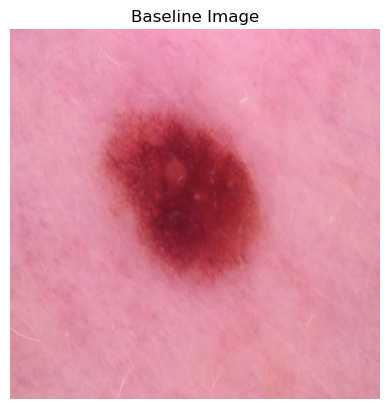

In [18]:
baseline = test_df.sample(n=1, random_state=42)
baseline_filepath = baseline["filepath"].values[0]
baseline_masked_filepath = baseline_filepath.replace("data/", "mask/")

ita = IndividualTypologyAngle(baseline_masked_filepath)
baseline_mean_ita = ita.get_mean_ita()
baseline_nuance_ita = ita.get_nuance_ita()

print(f"Baseline File Path: {baseline_filepath}")
print(f"Mean ITA: {baseline_mean_ita}")

image = cv2.imread(baseline_filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis("off")
plt.title("Baseline Image")
plt.show()

In [19]:
means = []
distances = []
tones = []

for _, row in test_df.iterrows():
    masked_filepath = row["filepath"].replace("data/", "mask/")
    ita = IndividualTypologyAngle(masked_filepath)
    mean_ita = ita.get_mean_ita()
    means.append(mean_ita)
    tones.append(ita.map_skin_tone(mean_ita))
    nuance_ita = ita.get_nuance_ita()
    dm = DistanceMeasure(baseline_nuance_ita, nuance_ita)
    distance = dm.sign_wasserstein_distance()
    distances.append(distance)

test_df["mean ita"] = means
test_df["skin tone"] = tones
test_df["distance"] = distances
print("Complete")

Complete


In [20]:
test_df["skin tone"]

4530    Very Light
8210          Dark
3641    Very Light
8573    Very Light
7080    Very Light
           ...    
8490    Very Light
1951    Very Light
1443    Very Light
5599    Very Light
8507    Very Light
Name: skin tone, Length: 1564, dtype: object

https://scholarlycommons.henryford.com/cgi/viewcontent.cgi?article=1624&context=dermatology_articles

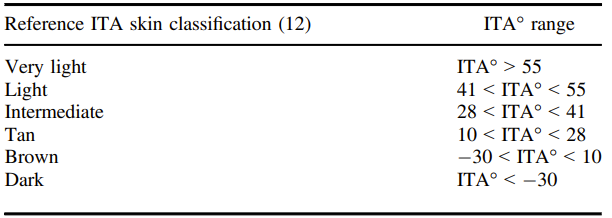

## Data Export

In [21]:
train_df.to_csv(f"{root}exp/train_df.csv", index=False)
valid_df.to_csv(f"{root}exp/valid_df.csv", index=False)
test_df.to_csv(f"{root}exp/test_df.csv", index=False)